## Background

The data set contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. We are going toidentify high-value customers by using different segmentation methods.

## Import Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-segmentation-dataset/Online Retail.xlsx


## Load Data

In [2]:
df = pd.read_excel('/kaggle/input/customer-segmentation-dataset/Online Retail.xlsx')

## EDA

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


There are null values in the columns "Description" and "CustomerID". Transactions with negative values of Quantity and UnitPrice need further investigation. Next, let check the data quality by checking the record count of each month.

In [6]:
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['YearMonth'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [7]:
df['YearMonth'].value_counts().sort_index()

YearMonth
2010-12    42481
2011-01    35147
2011-02    27707
2011-03    36748
2011-04    29916
2011-05    37030
2011-06    36874
2011-07    39518
2011-08    35284
2011-09    50226
2011-10    60742
2011-11    84711
2011-12    25525
Name: count, dtype: int64

A sudden increase of transaction are observed in the months 2011-09 to 2011-11. 

In [8]:
df.groupby('YearMonth').nunique().sort_index()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear
YearMonth,,,,,,,,,
2010-12,2025,2822,2760,206,1770,295,948,24,1
2011-01,1476,2645,2566,175,1349,330,783,24,1
2011-02,1393,2431,2372,167,1311,295,798,24,1
2011-03,1983,2562,2506,241,1808,327,1020,24,1
2011-04,1744,2558,2456,203,1540,272,899,28,1
2011-05,2162,2505,2480,206,1931,331,1079,21,1
2011-06,2012,2672,2639,216,1825,340,1051,26,1
2011-07,1927,2748,2693,191,1735,327,993,24,1
2011-08,1737,2614,2609,229,1608,301,980,25,1


From the table above, we can see that the sudden increase of stock transactions of 2011-09 to 2011-11 mainly from the increase of customers.

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
InvoiceYear         0
YearMonth           0
dtype: int64

In [10]:
df[df['Description'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,YearMonth
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,2010,2010-12
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,2010,2010-12
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010,2010-12
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010,2010-12
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,2010,2010-12
...,...,...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom,2011,2011-12
535326,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom,2011,2011-12
535332,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom,2011,2011-12
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom,2011,2011-12


In [11]:
df[df['Description'].isnull()]['UnitPrice'].value_counts()

UnitPrice
0.0    1454
Name: count, dtype: int64

All the transactions with null values of Description have UnitPrice=0.0.

In [12]:
df['CustomerID'] = df['CustomerID'].astype('str')

In [13]:
df['CustomerID'].value_counts()

CustomerID
nan        135080
17841.0      7983
14911.0      5903
14096.0      5128
12748.0      4642
            ...  
13270.0         1
17763.0         1
17291.0         1
15668.0         1
15562.0         1
Name: count, Length: 4373, dtype: int64

There are 135,080 transactions with null CustomerID. Since we need the customer information after the segmentation. If the null CustomerID cannot be resolved, they have to be removed from the analysis.

In [14]:
df[df['CustomerID']=='nan']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,YearMonth
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,nan,United Kingdom,2010,2010-12
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,nan,United Kingdom,2010,2010-12
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,nan,United Kingdom,2010,2010-12
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,nan,United Kingdom,2010,2010-12
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,nan,United Kingdom,2010,2010-12
...,...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,nan,United Kingdom,2011,2011-12
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,nan,United Kingdom,2011,2011-12
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,nan,United Kingdom,2011,2011-12
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,nan,United Kingdom,2011,2011-12


In [15]:
df[df['CustomerID']=='nan']['InvoiceYear'].value_counts()

InvoiceYear
2011    119449
2010     15631
Name: count, dtype: int64

In [16]:
df['Country'].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [17]:
df[df['CustomerID']=='nan']['Country'].value_counts()

Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: count, dtype: int64

In [18]:
df[df['Quantity']<=0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,YearMonth
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010,2010-12
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010,2010-12
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,2010-12
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,2010-12
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,2010-12
...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,2011,2011-12
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,2011,2011-12
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,2011,2011-12
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,2011,2011-12


Transactions with negative Quantity have special pattern in the InvoiceNo. Let's dig into it.

In [19]:
df[df['Quantity']<=0]['InvoiceNo'].astype(str).str[0].value_counts()

InvoiceNo
C    9288
5    1336
Name: count, dtype: int64

In [20]:
df_inv = df[df['Quantity']<=0]
df_inv['InvoiceNo'] = df_inv['InvoiceNo'].astype(str)

Let's check if any finding from Description column.

In [21]:
print(df_inv[df_inv['InvoiceNo'].str.startswith('C')]['Description'].value_counts()[0:20].to_string())

Description
Manual                                244
REGENCY CAKESTAND 3 TIER              181
POSTAGE                               126
JAM MAKING SET WITH JARS               87
Discount                               77
SET OF 3 CAKE TINS PANTRY DESIGN       74
SAMPLES                                61
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        54
RECIPE BOX PANTRY YELLOW DESIGN        47
WOOD 2 DRAWER CABINET WHITE FINISH     45
LUNCH BAG RED RETROSPOT                44
JUMBO BAG RED RETROSPOT                44
GREEN REGENCY TEACUP AND SAUCER        42
WHITE HANGING HEART T-LIGHT HOLDER     42
RED RETROSPOT CAKE STAND               42
SMALL GLASS HEART TRINKET POT          40
SET OF 3 REGENCY CAKE TINS             37
POPCORN HOLDER                         36
SILVER HANGING T-LIGHT HOLDER          35


In [22]:
print(df_inv[df_inv['InvoiceNo'].str.startswith('5')]['Description'].value_counts()[0:20].to_string())

Description
check                     120
damages                    45
damaged                    42
?                          41
sold as set on dotcom      20
Damaged                    14
thrown away                 9
Unsaleable, destroyed.      9
??                          7
wet damaged                 5
damages?                    5
ebay                        5
smashed                     4
missing                     3
wet pallet                  3
CHECK                       3
sold as 1                   2
incorrect stock entry.      2
crushed                     2
adjustment                  2


### Data Clean

By digging into the details, we cannot verify the transactions with negative Quantity values. For simplicity, let's remove null value and transactions with negative values of Quantity and UnitPrice.

In [23]:
df.dropna(inplace=True)
df_clean = df[df['Quantity'] > 0]
df_clean = df_clean[df_clean['UnitPrice']>0]
df_clean = df_clean[df_clean['CustomerID']!='nan']

In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
 8   InvoiceYear  397884 non-null  int32         
 9   YearMonth    397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(6)
memory usage: 31.9+ MB


In [25]:
df_clean.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
InvoiceYear    0
YearMonth      0
dtype: int64

In [26]:
df_clean.describe()

,Quantity,InvoiceDate,UnitPrice,InvoiceYear
count,397884.000000,397884,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,2010.934260
min,1.000000,2010-12-01 08:26:00,0.001000,2010.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,2011.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,2011.000000
75%,12.000000,2011-10-20 14:33:00,3.750000,2011.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,2011.000000
std,179.331775,NaN,22.097877,0.247828


In [27]:
df_clean['Country'].value_counts()

Country
United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


In [28]:
print("Number of customers: ",len(df_clean['CustomerID'].unique()))
print("Number of stocks: ",len(df_clean['StockCode'].unique()))

Number of customers:  4338
Number of stocks:  3665


In [29]:
df_clean['YearMonth'].value_counts().sort_index()

YearMonth
2010-12    26157
2011-01    21229
2011-02    19927
2011-03    27175
2011-04    22642
2011-05    28320
2011-06    27185
2011-07    26825
2011-08    27007
2011-09    40028
2011-10    49554
2011-11    64531
2011-12    17304
Name: count, dtype: int64

## Clustering

Now we are ready for the customer segmentation. We will start from feature engineering to create some important features for the clustering process. A good starting point is to define features using the RFM approach. 

RFM is a method used for analyzing customer value and segmenting customers which is commonly used in database marketing and direct marketing [1]. RFM stands for the three dimensions:
- Recency – How recently did the customer purchase?
- Frequency – How often do they purchase?
- Monetary Value – How much do they spend? 

In [30]:
anchorDate = dt.datetime(2011,12,10)
df_clean['TotalValue'] = df_clean['Quantity']*df_clean['UnitPrice']
rfm=df_clean.groupby('CustomerID').agg({'InvoiceDate': lambda x: (anchorDate-x.max()).days,
                                       'InvoiceNo': lambda x: len(x),
                                       'TotalValue': lambda x: x.sum()})
rfm= rfm.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalValue':'Monetary'})

In [31]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


Let's check the distribution of these features.

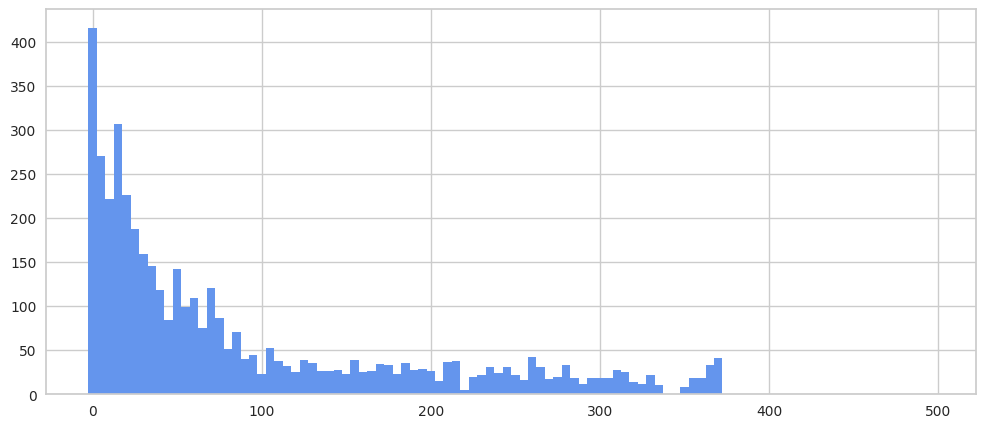

In [32]:
plt.figure(figsize = (12,5))
hist = plt.hist(rfm['Recency'], bins=100, range=[0,500], align='left', color='cornflowerblue')

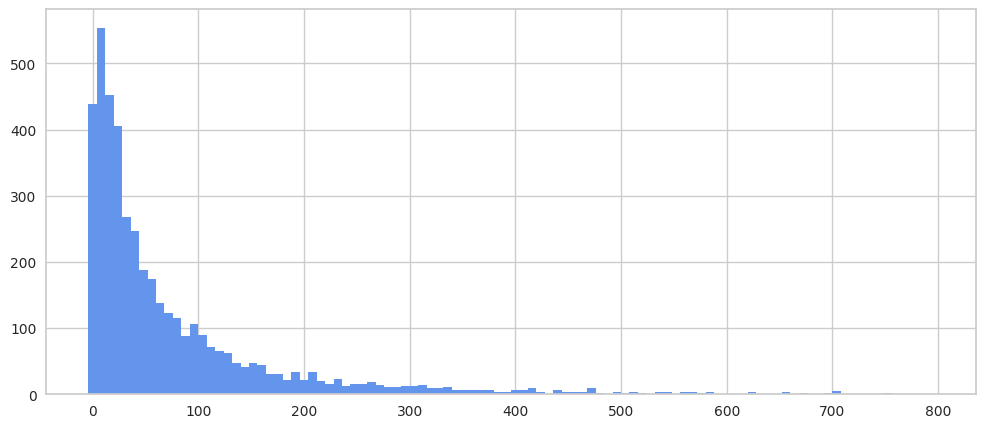

In [33]:
plt.figure(figsize = (12,5))
hist = plt.hist(rfm['Frequency'], bins=100, range=[0,800], align='left', color='cornflowerblue')

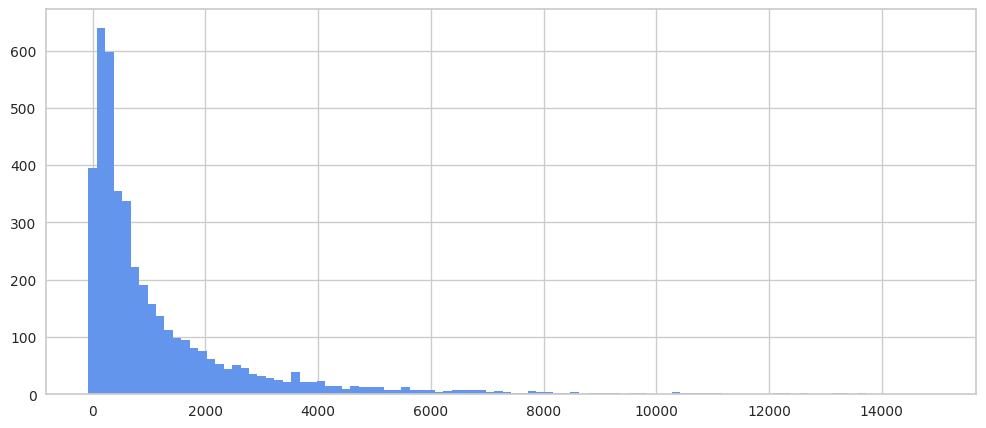

In [34]:
plt.figure(figsize = (12,5))
hist = plt.hist(rfm['Monetary'], bins=100, range=[0,15000], align='left', color='cornflowerblue')

All three features are right-skewed, with particularly large values in Frequency and Monetary. When using distance-based models such as KMeans, these large values can skew the model results, as KMeans relies on Euclidean distance. A good practice is to apply a logarithmic transformation to these features.

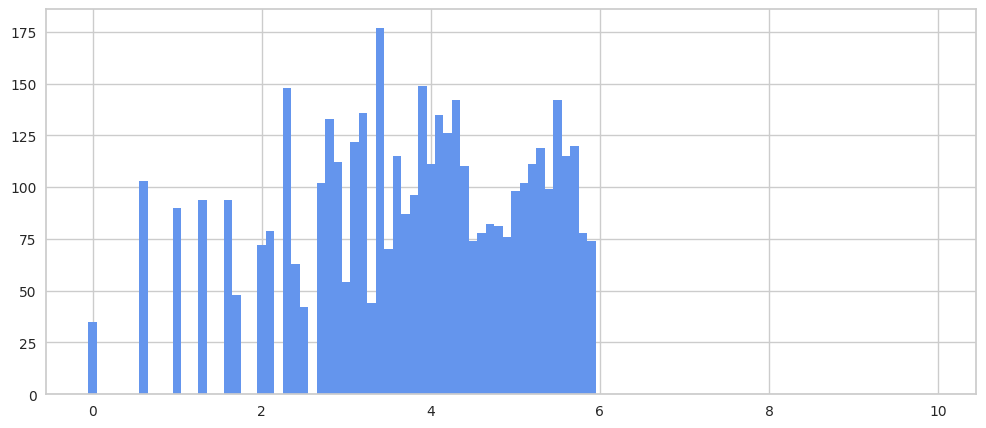

In [35]:
plt.figure(figsize = (12,5))
hist = plt.hist(np.log(rfm['Recency']+1), bins=100, range=[0,10], align='left', color='cornflowerblue')

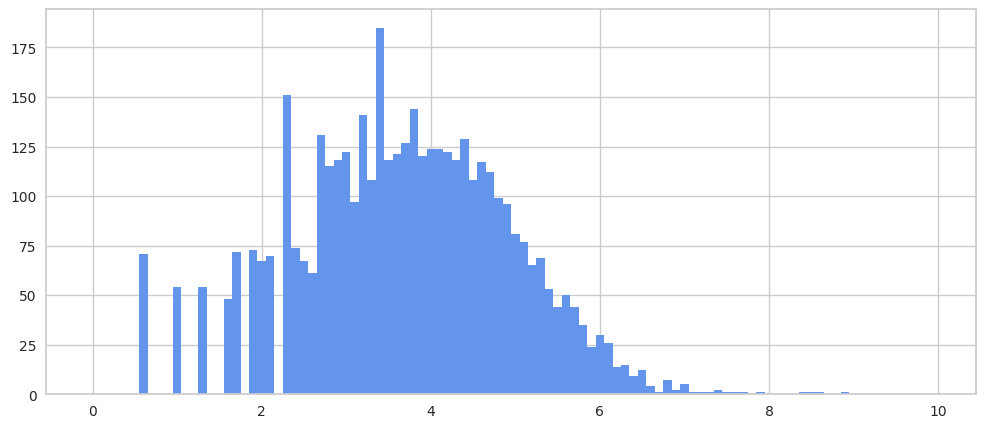

In [36]:
plt.figure(figsize = (12,5))
hist = plt.hist(np.log(rfm['Frequency']+1), bins=100, range=[0,10], align='left', color='cornflowerblue')

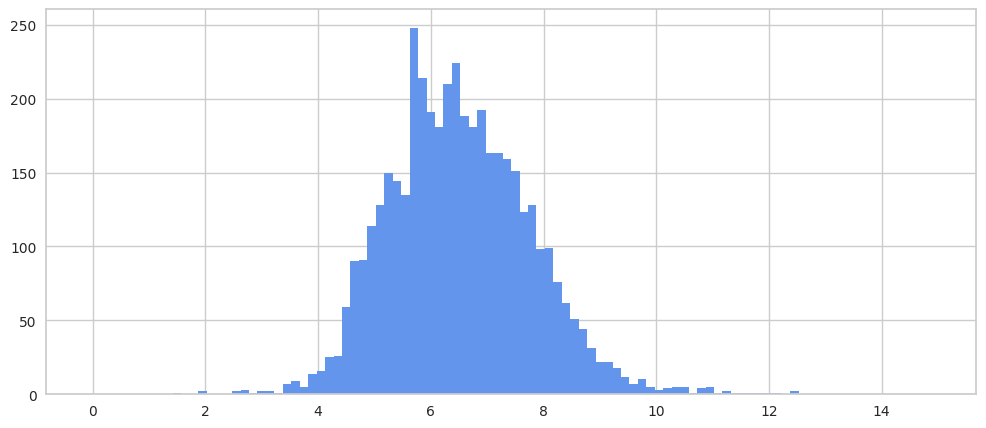

In [37]:
plt.figure(figsize = (12,5))
hist = plt.hist(np.log(rfm['Monetary']+1), bins=100, range=[0,15], align='left', color='cornflowerblue')

After taking the logarithm, the distributions are close to normal and their scales are the same.

In [38]:
rfm['log_Recency'] = np.log(rfm['Recency']+1)
rfm['log_Frequency'] = np.log(rfm['Frequency']+1)
rfm['log_Monetary'] = np.log(rfm['Monetary']+1)

In [39]:
rfm.head()

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary
CustomerID,,,,,,
12346.0,325,1,77183.60,5.786897,0.693147,11.253955
12347.0,2,182,4310.00,1.098612,5.209486,8.368925
12348.0,75,31,1797.24,4.330733,3.465736,7.494564
12349.0,18,73,1757.55,2.944439,4.304065,7.472245
12350.0,310,17,334.40,5.739793,2.890372,5.815324


In [40]:
rfm.describe()

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.059474,91.720609,2054.266460,3.801055,3.737143,6.593627
std,100.012264,228.785094,8989.230441,1.383620,1.250560,1.257578
min,0.000000,1.000000,3.750000,0.000000,0.693147,1.558145
25%,17.000000,17.000000,307.415000,2.890372,2.890372,5.731446
50%,50.000000,41.000000,674.485000,3.931826,3.737670,6.515431
75%,141.750000,100.000000,1661.740000,4.961090,4.615121,7.416222
max,373.000000,7847.000000,280206.020000,5.924256,8.968014,12.543284


It depends on the business scenarios to determine the number of segmentations. We start from KMeans to identify the number of classes.

### Kmeans

K-Means is a centroid-based clustering algorithm that partitions data into k clusters based on their distance from the mean (centroid) of each cluster.

In [41]:
#scaler = MinMaxScaler((0, 1))
#df_rfm = scaler.fit_transform(rfm.loc[:,['log_Recency','log_Frequency','log_Monetary']])
df_rfm=np.array(rfm.loc[:,['log_Recency','log_Frequency','log_Monetary']])

In [42]:
df_rfm

array([[ 5.78689738,  0.69314718, 11.25395523],
       [ 1.09861229,  5.20948615,  8.36892517],
       [ 4.33073334,  3.4657359 ,  7.49456369],
       ...,
       [ 2.07944154,  2.56494936,  5.1876651 ],
       [ 1.38629436,  6.62936325,  7.64772879],
       [ 3.76120012,  4.26267988,  7.51658563]])

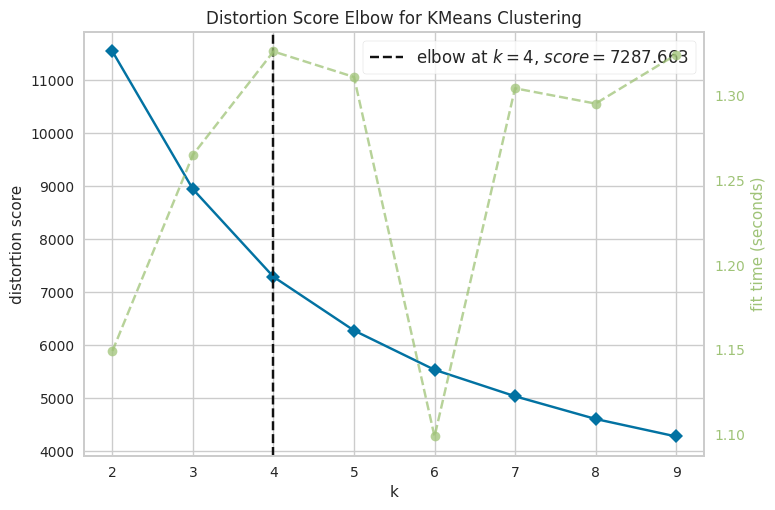

In [43]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(df_rfm) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

In [44]:
km_mdl = KMeans(n_clusters=4, random_state=32)

km = km_mdl.fit_predict(df_rfm)

In [45]:
np.unique(km)

array([0, 1, 2, 3], dtype=int32)

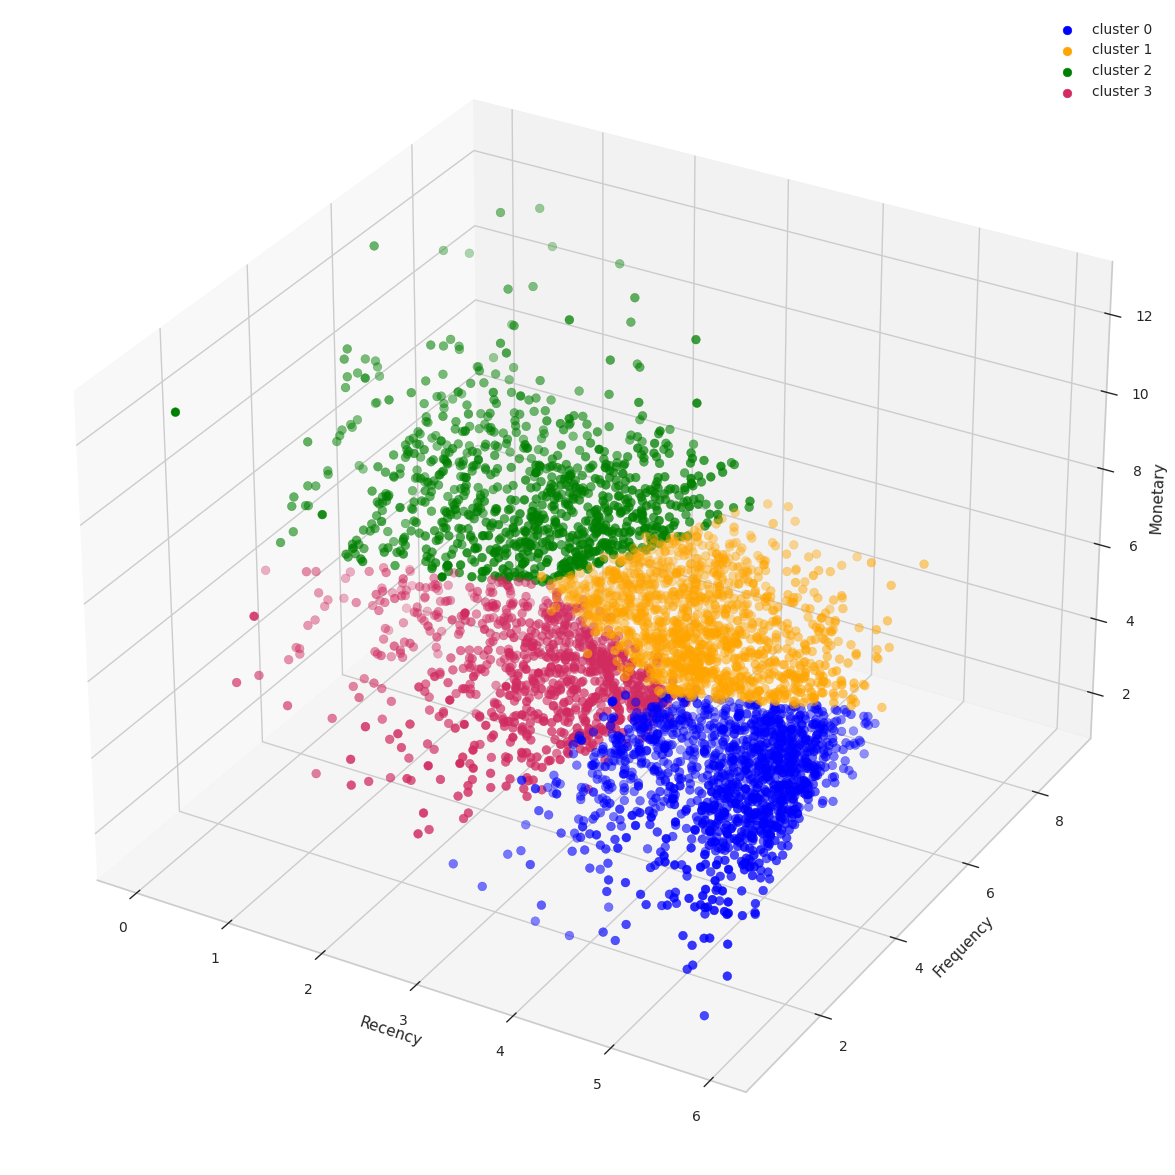

In [46]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_rfm[km == 0,0],df_rfm[km == 0,1],df_rfm[km == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(df_rfm[km == 1,0],df_rfm[km == 1,1],df_rfm[km == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(df_rfm[km == 2,0],df_rfm[km == 2,1],df_rfm[km == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(df_rfm[km == 3,0],df_rfm[km == 3,1],df_rfm[km == 3,2], s = 40 , color = '#D12B60', label = "cluster 3")
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend()
plt.show()

The figure above shows the 4 clusters from KMeans. The results seems promising: Cluster 2 (green) is the class with small Receny, high Frequency and high Monetary, while Cluster 0 (blue) is the class with large Receny, low Frequency and small Monetary. We will check more detials later.

### RFM

In [47]:
r_quarters = rfm['Recency'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
f_quarters = rfm['Frequency'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
m_quarters = rfm['Monetary'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
quartile_spread = pd.DataFrame(list(zip(r_quarters, f_quarters, m_quarters)), 
                      columns=['Q_Recency','Q_Frequency', 'Q_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
quartile_spread

,Q_Recency,Q_Frequency,Q_Monetary
min,0.00,1.0,3.750
first_part,17.00,17.0,307.415
second_part,50.00,41.0,674.485
third_part,141.75,100.0,1661.740
max,373.00,7847.0,280206.020


In [48]:
r_breaks = rfm['Recency'].quantile(q=[0.0, 0.35,0.55,0.8, 1]).to_list()
f_breaks = rfm['Frequency'].quantile(q=[0.0, 0.6,0.8,0.95, 1]).to_list()
m_breaks = rfm['Monetary'].quantile(q=[0.0, 0.2,0.6,0.85, 1]).to_list()
quartile_spread = pd.DataFrame(list(zip(r_breaks, f_breaks, m_breaks)), 
                      columns=['Q_Recency','Q_Frequency', 'Q_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
quartile_spread

,Q_Recency,Q_Frequency,Q_Monetary
min,0.0,1.00,3.7500
first_part,26.0,58.00,250.1940
second_part,60.0,121.00,942.2760
third_part,179.0,314.15,2639.0435
max,373.0,7847.00,280206.0200


In [49]:
rfm['r_score'] = pd.cut(rfm['Recency'], bins=r_breaks, labels=[4,3,2,1],include_lowest=True)
rfm['f_score'] = pd.cut(rfm['Frequency'], bins=f_breaks, labels=[1,2,3,4],include_lowest=True)
rfm['m_score'] = pd.cut(rfm['Monetary'], bins=m_breaks, labels=[1,2,3,4],include_lowest=True)
rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

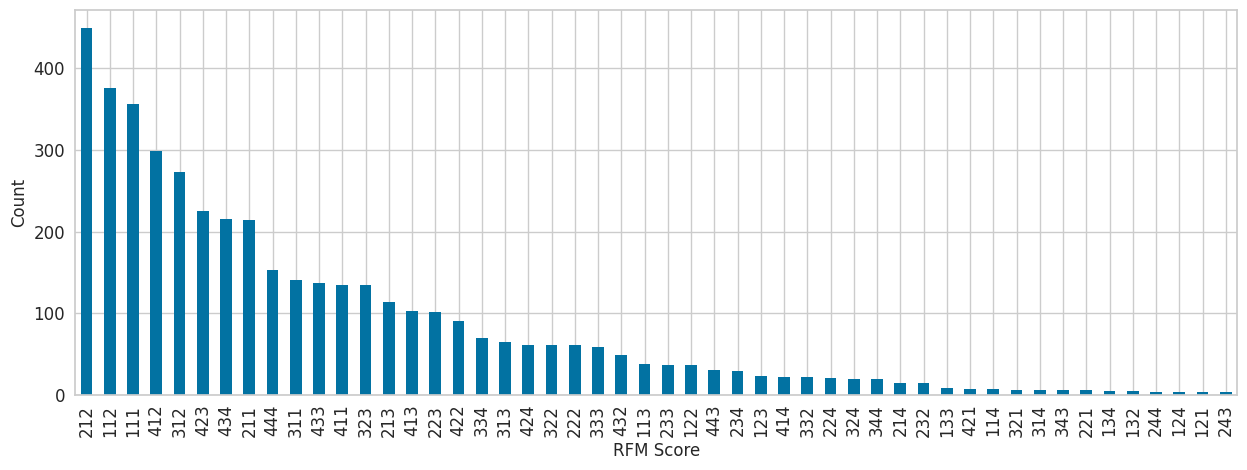

In [50]:
ax = rfm['rfm_score'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [51]:
rfm[rfm['rfm_score']=='444'].sort_values('Recency',ascending=False)

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary,r_score,f_score,m_score,rfm_score
CustomerID,,,,,,,,,,
13451.0,26,443,2976.15,3.295837,6.095825,7.998722,4,4,4,444
12867.0,26,538,4036.82,3.295837,6.289716,8.303460,4,4,4,444
12415.0,24,714,124914.53,3.218876,6.572283,11.735393,4,4,4,444
17220.0,24,472,3198.25,3.218876,6.159095,8.070672,4,4,4,444
17377.0,23,418,4100.92,3.178054,6.037871,8.319210,4,4,4,444
...,...,...,...,...,...,...,...,...,...,...
17428.0,0,328,17256.85,0.000000,5.796058,9.756022,4,4,4,444
13069.0,0,425,4436.12,0.000000,6.054439,8.397761,4,4,4,444
17581.0,0,440,11045.04,0.000000,6.089045,9.309827,4,4,4,444


### Aggregate the RFM results

In [52]:
agg_map = {
    r'[3-4][3-4]4': '01_core',
    r'[3-4][3-4]3': '02_loyal_large',
    r'[3-4][1-2][3-4]': '03_new_large',
    r'[1-2][1-2][3-4]': '04_promising',
    r'[3-4][3-4][1-2]': '05_loyal_small',
    r'[3-4][1-2][1-2]': '06_new_small',
    r'[1-2][3-4][3-4]': '07_lost_loyal_large',
    r'[1-2][3-4][1-2]': '08_lost_loyal_small',
    r'[1-2][1-2][1-2]': '09_low_priority',
}

rfm['RFM_segment'] = rfm['rfm_score'].replace(agg_map, regex=True)

rfm.reset_index()
rfm.head()

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary,r_score,f_score,m_score,rfm_score,RFM_segment
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,5.786897,0.693147,11.253955,1,1,4,114,04_promising
12347.0,2,182,4310.00,1.098612,5.209486,8.368925,4,3,4,434,01_core
12348.0,75,31,1797.24,4.330733,3.465736,7.494564,2,1,3,213,04_promising
12349.0,18,73,1757.55,2.944439,4.304065,7.472245,4,2,3,423,03_new_large
12350.0,310,17,334.40,5.739793,2.890372,5.815324,1,1,2,112,09_low_priority


In [53]:
rfm[["RFM_segment","Recency","Frequency","Monetary"]].groupby(["RFM_segment"]).agg(["mean","count"])

Recency         Frequency            Monetary      
                           mean count        mean count          mean count
RFM_segment                                                                
01_core               15.072052   458  395.087336   458  10398.632314   458
02_loyal_large        18.446352   233  221.901288   233   1829.975322   233
03_new_large          22.270440   636   71.279874   636   2654.884811   636
04_promising         132.071207   323   57.455108   323   2340.751331   323
05_loyal_small        22.802817    71  157.535211    71    722.615070    71
06_new_small          27.851779  1012   35.143281  1012    433.397521  1012
07_lost_loyal_large  121.658824    85  191.505882    85   2766.812012    85
08_lost_loyal_small  158.315789    19  153.578947    19    680.357895    19
09_low_priority      191.989340  1501   23.579614  1501    359.674119  1501

In [54]:
rfm['KMean_Segment'] = km

In [55]:
rfm[["KMean_Segment","Recency","Frequency","Monetary"]].groupby(["KMean_Segment"]).agg(["mean","count"])

Recency         Frequency           Monetary      
                     mean count        mean count         mean count
KMean_Segment                                                       
0              200.248851  1306   16.167688  1306   315.446555  1306
1               83.857475  1291   86.202169  1291  1608.988709  1291
2               10.208099   889  269.884139   889  6773.513915   889
3               24.053991   852   29.994131   852   470.160106   852

From the table above, the results from KMeans can be interpreted as:

- Cluster 2: Core customers
- Cluster 1: Loyal customers
- Cluster 3: New customers
- Cluster 0: Low priority

This is consistent with the figure of the clusters we previously saw.

## Model Comparison

In [56]:
rfm['KMean_Segment'] = rfm['KMean_Segment'].astype(str)
km_map = {
    r'0': 'Low priority',
    r'1': 'Loyal',
    r'3': 'New',
    r'2': 'Core',
}

rfm['KMeans_seg_trans'] = rfm['KMean_Segment'].replace(km_map, regex=True)

In [57]:
rfm.head()

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary,r_score,f_score,m_score,rfm_score,RFM_segment,KMean_Segment,KMeans_seg_trans
CustomerID,,,,,,,,,,,,,
12346.0,325,1,77183.60,5.786897,0.693147,11.253955,1,1,4,114,04_promising,1,Loyal
12347.0,2,182,4310.00,1.098612,5.209486,8.368925,4,3,4,434,01_core,2,Core
12348.0,75,31,1797.24,4.330733,3.465736,7.494564,2,1,3,213,04_promising,1,Loyal
12349.0,18,73,1757.55,2.944439,4.304065,7.472245,4,2,3,423,03_new_large,1,Loyal
12350.0,310,17,334.40,5.739793,2.890372,5.815324,1,1,2,112,09_low_priority,0,Low priority


In [58]:
rfm[["KMeans_seg_trans",'RFM_segment']].groupby(["KMeans_seg_trans","RFM_segment"])["RFM_segment"].agg(['count'])

count
KMeans_seg_trans RFM_segment               
Core             01_core                416
                 02_loyal_large         164
                 03_new_large           260
                 05_loyal_small          26
                 06_new_small            23
Low priority     04_promising            30
                 06_new_small            72
                 09_low_priority       1204
Loyal            01_core                 42
                 02_loyal_large          69
                 03_new_large           312
                 04_promising           293
                 05_loyal_small          44
                 06_new_small           148
                 07_lost_loyal_large     85
                 08_lost_loyal_small     19
                 09_low_priority        279
New              03_new_large            64
                 05_loyal_small           1
                 06_new_small           769
                 09_low_priority         18

## Conclusion

In our analysis, we applied both KMeans clustering and RFM segmentation methods to the retail dataset to identify distinct customer segments. The results revealed a significant overlap between the customer segments identified by both methods. This overlap suggests that the segments derived from the KMeans clustering align closely with those defined by RFM analysis, indicating consistency and reliability in the segmentation process. 

## References
- [1]: https://en.wikipedia.org/wiki/RFM_(market_research)
- [2]: https://towardsdatascience.com/rfm-segmentation-using-quartiles-and-jenks-natural-breaks-924f4d8baee1
- [3]: https://www.rfmcalc.com/ecommerce-reports/rfm-segmentation/
- [4]: https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization
- [5]: https://stats.stackexchange.com/questions/143974/jenks-natural-breaks-in-python-how-to-find-the-optimum-number-of-breaks/144075#144075
- [6]: https://www.kaggle.com/code/eminecerit/rfm-vs-k-means-in-customer-segmentation
- [7]: https://www.kaggle.com/code/arushchillar/kmeans-clustering-using-different-distance-metrics
- [8]: https://www.barilliance.com/rfm-analysis/#:~:text=RFM%20analysis%20is%20a%20data,much%20they've%20spent%20overall.